In [ ]:
# Install necessary libraries
!pip install scikit-learn pandas numpy matplotlib seaborn nltk openpyxl

# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# ----------------------------------------------------------------------
# ⚠️ DATA LOADING INSTRUCTIONS:
# 1. Click the 'Files' icon on the left sidebar in Google Colab.
# 2. Upload your data file (e.g., 'my_legal_data.csv' or 'my_legal_data.xlsx').
# 3. Ensure your file has two columns: 'text' (for document content) and 'category' (for the label).
# 4. Change the 'FILE_NAME' below to match your uploaded file.
# ----------------------------------------------------------------------

FILE_NAME = 'legal_data.csv' # ⬅️ CHANGE THIS TO YOUR FILE NAME!

try:
    if FILE_NAME.endswith('.csv'):
        df = pd.read_csv(FILE_NAME)
    elif FILE_NAME.endswith(('.xls', '.xlsx')):
        # You need the 'openpyxl' library installed (included in the first install line)
        df = pd.read_excel(FILE_NAME)
    else:
        raise ValueError("Unsupported file type.")

    # Simple check to ensure required columns exist
    if 'text' not in df.columns or 'category' not in df.columns:
        raise ValueError("File must contain 'text' and 'category' columns.")

    print(f"Data successfully loaded from '{FILE_NAME}'.")

except (FileNotFoundError, ValueError) as e:
    print(f"Error loading data file: {e}. Using sample dictionary data instead.")
    # FALLBACK SAMPLE DATA (if file load fails)
    data = {
        'text': [
            "This contract agreement is made for the sale of goods between both parties and is valid for one year.",
            "The Supreme Court ruled that the previous appellate decision is reversed and remanded for further action.",
            "Notice is hereby served that the lease on property 4B shall terminate in 30 days due to non-payment.",
            "The appellate court, relying on Smith v. Jones, stated that precedent dictates the ruling must be upheld.",
            "We, the undersigned, agree to the terms of this non-disclosure employment agreement effective immediately.",
            "This case involves a review of the summary judgment granted by the lower court on matters of fact.",
            "Please take notice of the impending changes to the company's official travel policy, starting next month.",
            "In accordance with established case law, the plaintiff's argument holds no legal standing.",
            "An indemnification clause protects a party from liability arising from third-party claims under this contract.",
            "The court hereby enters a final decision on the 15th day of October, finding in favor of the defendant.",
            "Final notice of pending litigation will be sent to all shareholders by certified mail this week.",
            "Legal precedent from the landmark case Brown v. Board is controlling in this jurisdiction.",
        ],
        'category': [
            'Contract', 'Judgment', 'Notice', 'Case Law',
            'Contract', 'Judgment', 'Notice', 'Case Law',
            'Contract', 'Judgment', 'Notice', 'Case Law'
        ]
    }
    df = pd.DataFrame(data)


print(f"Total samples loaded: {len(df)}")
print("Data Head:")
print(df.head())

Error loading data file: [Errno 2] No such file or directory: 'legal_data.csv'. Using sample dictionary data instead.
Total samples loaded: 12
Data Head:
                                                text  category
0  This contract agreement is made for the sale o...  Contract
1  The Supreme Court ruled that the previous appe...  Judgment
2  Notice is hereby served that the lease on prop...    Notice
3  The appellate court, relying on Smith v. Jones...  Case Law
4  We, the undersigned, agree to the terms of thi...  Contract


In [ ]:
print("--- Data Preprocessing Explanation ---")
print("1. **Cleaning**: Legal texts are converted to lowercase and stripped of punctuation/numbers to normalize the data.")
print("2. **Stopword Removal**: Common, non-informative words (e.g., 'the', 'is', 'a') are removed, as they don't help distinguish document categories.")
print("3. **Lemmatization**: Words are reduced to their root form (e.g., 'agreements' becomes 'agreement'). This reduces feature size and helps the model generalize better.")
print("\nThese steps ensure the text is clean and focused on content-bearing terms before numerical conversion.")

--- Data Preprocessing Explanation ---
1. **Cleaning**: Legal texts are converted to lowercase and stripped of punctuation/numbers to normalize the data.
2. **Stopword Removal**: Common, non-informative words (e.g., 'the', 'is', 'a') are removed, as they don't help distinguish document categories.
3. **Lemmatization**: Words are reduced to their root form (e.g., 'agreements' becomes 'agreement'). This reduces feature size and helps the model generalize better.

These steps ensure the text is clean and focused on content-bearing terms before numerical conversion.


In [ ]:
# Initialize NLP tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Applies cleaning, stopword removal, and lemmatization."""
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Lemmatize and remove stop words
    text = ' '.join(
        lemmatizer.lemmatize(word)
        for word in text.split()
        if word not in stop_words and len(word) > 2
    )
    return text

# Apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)

print("Data Preprocessing Complete. Cleaned Data Sample:")
print(df[['text', 'cleaned_text', 'category']].head())

Data Preprocessing Complete. Cleaned Data Sample:
                                                text  \
0  This contract agreement is made for the sale o...   
1  The Supreme Court ruled that the previous appe...   
2  Notice is hereby served that the lease on prop...   
3  The appellate court, relying on Smith v. Jones...   
4  We, the undersigned, agree to the terms of thi...   

                                        cleaned_text  category  
0  contract agreement made sale good party valid ...  Contract  
1  supreme court ruled previous appellate decisio...  Judgment  
2  notice hereby served lease property shall term...    Notice  
3  appellate court relying smith jones stated pre...  Case Law  
4  undersigned agree term nondisclosure employmen...  Contract  


In [ ]:
print("--- Feature Extraction and Model Training Explanation ---")
print("1. **TF-IDF (Term Frequency-Inverse Document Frequency)**: This technique converts the cleaned text into numerical vectors.")
print("   - It weighs words based on how frequently they appear in a document (**TF**) versus how rare they are across all documents (**IDF**).")
print("   - Words highly specific to a legal category (e.g., 'arbitration' in Contract) receive a higher score.")
print("2. **Data Split**: The dataset is split into 70% for training (model learning) and 30% for testing (model evaluation). The `stratify` parameter ensures an equal representation of all categories in both sets.")
print("3. **SVM (Support Vector Machine) Training**: SVM works by finding an optimal boundary (hyperplane) that maximally separates the data points (documents) belonging to different categories in the high-dimensional TF-IDF space.")

--- Feature Extraction and Model Training Explanation ---
1. **TF-IDF (Term Frequency-Inverse Document Frequency)**: This technique converts the cleaned text into numerical vectors.
   - It weighs words based on how frequently they appear in a document (**TF**) versus how rare they are across all documents (**IDF**).
   - Words highly specific to a legal category (e.g., 'arbitration' in Contract) receive a higher score.
2. **Data Split**: The dataset is split into 70% for training (model learning) and 30% for testing (model evaluation). The `stratify` parameter ensures an equal representation of all categories in both sets.
3. **SVM (Support Vector Machine) Training**: SVM works by finding an optimal boundary (hyperplane) that maximally separates the data points (documents) belonging to different categories in the high-dimensional TF-IDF space.


In [ ]:
# 1. Split data into training and testing sets
X = df['cleaned_text']
y = df['category']

# Use 70% for training and 30% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# 2. Initialize and Fit the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF Vectorizer Trained.")
print(f"Training feature set size: {X_train_tfidf.shape[1]} features.")

# 3. Train the SVM Model
print("\nStarting SVM Model Training...")
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
print("Model Training Complete.")

# 4. Predictions on Test Set
y_pred = svm_model.predict(X_test_tfidf)

Training samples: 8
Testing samples: 4
TF-IDF Vectorizer Trained.
Training feature set size: 72 features.

Starting SVM Model Training...
Model Training Complete.


In [ ]:
print("--- Model Evaluation Metrics ---")

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Model Accuracy: {overall_accuracy:.4f}")

# Display Precision, Recall, and F1-score for each class
report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

print("\nDetailed Metrics per Category:")
metrics_df = pd.DataFrame(report).transpose()

# Display F1-Score, Recall, Precision, and support only
print(metrics_df[['f1-score', 'recall', 'precision']].round(4))

print("\n--- Metric Definitions ---")
print(" - **Accuracy**: Overall ratio of correct predictions to total predictions.")
print(" - **Precision**: Out of all documents predicted as a category, how many were actually correct.")
print(" - **Recall**: Out of all true documents of a category, how many did the model correctly find.")
print(" - **F1-Score**: The harmonic mean of Precision and Recall, providing a single metric that balances both.")


--- Model Evaluation Metrics ---
Overall Model Accuracy: 1.0000

Detailed Metrics per Category:
              f1-score  recall  precision
Case Law           1.0     1.0        1.0
Contract           1.0     1.0        1.0
Judgment           1.0     1.0        1.0
Notice             1.0     1.0        1.0
accuracy           1.0     1.0        1.0
macro avg          1.0     1.0        1.0
weighted avg       1.0     1.0        1.0

--- Metric Definitions ---
 - **Accuracy**: Overall ratio of correct predictions to total predictions.
 - **Precision**: Out of all documents predicted as a category, how many were actually correct.
 - **Recall**: Out of all true documents of a category, how many did the model correctly find.
 - **F1-Score**: The harmonic mean of Precision and Recall, providing a single metric that balances both.


--- Confusion Matrix Visualization ---


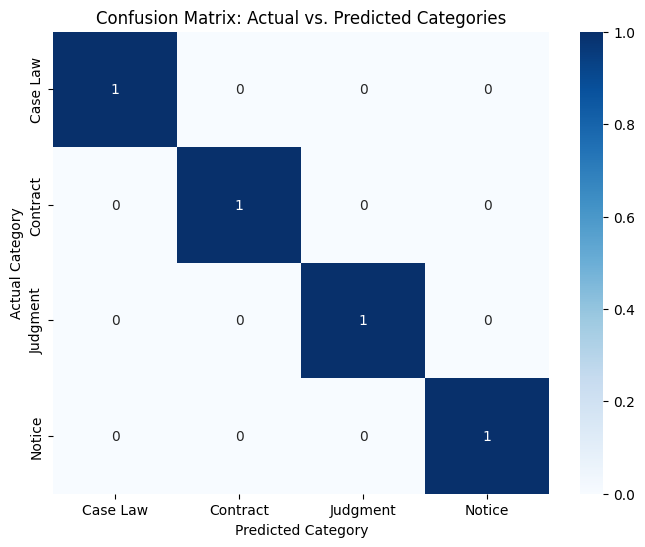


Confusion Matrix Explained:
 - The diagonal cells (top-left to bottom-right) represent **CORRECT** predictions.
 - The off-diagonal cells represent **INCORRECT** predictions (e.g., a 'Judgment' document predicted as 'Notice').


In [ ]:
print("--- Confusion Matrix Visualization ---")

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)

# Plot the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)

plt.title('Confusion Matrix: Actual vs. Predicted Categories')
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.show() # Display the confusion matrix graph

print("\nConfusion Matrix Explained:")
print(" - The diagonal cells (top-left to bottom-right) represent **CORRECT** predictions.")
print(" - The off-diagonal cells represent **INCORRECT** predictions (e.g., a 'Judgment' document predicted as 'Notice').")

In [ ]:
print("--- FINAL PREDICTION ON NEW DATA ---")

new_legal_texts = [
    "The client must sign the employment agreement immediately to finalize the terms.", # Expected: Contract
    "The High Court has issued a final decision, upholding the verdict of the previous panel.", # Expected: Judgment
    "A formal notice of injunction is served due to the violation of property rights.", # Expected: Notice
    "The plaintiff's lawyer argued that the established precedent from the case of Roe v. Wade should apply.", # Expected: Case Law
]

def predict_category(text_list, model, vectorizer):
    """Applies full pipeline (preprocess, transform, predict) to new texts."""
    results = []

    for text in text_list:
        # Preprocess the text
        cleaned_text = preprocess_text(text)

        # Transform the text
        text_vectorized = vectorizer.transform([cleaned_text])

        # Predict the category
        prediction = model.predict(text_vectorized)[0]

        results.append({
            'Input Text Snippet': text[:70] + '...',
            'Predicted Category': prediction
        })

    return pd.DataFrame(results)

# Run prediction
final_predictions_df = predict_category(new_legal_texts, svm_model, tfidf_vectorizer)

print("\nClassification Results:")
print(final_predictions_df)

--- FINAL PREDICTION ON NEW DATA ---

Classification Results:
                                  Input Text Snippet Predicted Category
0  The client must sign the employment agreement ...           Contract
1  The High Court has issued a final decision, up...           Judgment
2  A formal notice of injunction is served due to...             Notice
3  The plaintiff's lawyer argued that the establi...           Case Law
